### EE 699 Next Generation Wireless Networks 
- Assignment 02 
- Author: $\text{Rishabh Pomaje}$ 
- Contact: 210020036@iitdh.ac.in

- In this notebook, we will simulate the following queues and compare our empirical findings with the analytic results.
- Scheduling discipline used : _First-In-First-Out_.

In [1]:
# Dependencies :
import numpy as np
import queue_models as qm

import matplotlib.pyplot as plt 
%config InlineBackend.figure_format='svg'
# Set global parameters for publication quality
plt.rcParams.update({
    "text.usetex": True,            # Comment if TeX is unavailable on your machine 
    "font.family": "serif",          
})
import seaborn as sns 
sns.set_theme('paper')

In [2]:
# Global functions :
def factorial(n):
    n_fac = 1 
    for i in range(1, n+1):
        n_fac *= i
    
    return n_fac

In [3]:
# Global Definitions :
del_t = 10 ** -3            # smallest time resolution :: in some time units
total_simul_time = 3000     # In common time units
arrival_rate = 6            # Number of arrivals per unit time
departure_rate = 11         # Number of departure per unit time

#### M/M/1 Queue

- Note: The arrival rate should be lesser than the departure rate to achieve equilibrium.

In [4]:
queue_history, arr_Times, dep_Times, ind_Times = qm.m_m_1_q(total_simul_time, del_t, arrival_rate, departure_rate)

- Evolution of the state of the system

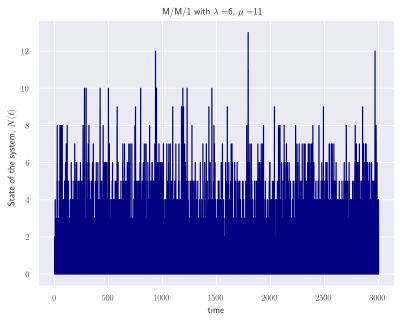

In [5]:
fig, axes = plt.subplots()
axes.plot(del_t * np.arange(int(total_simul_time / del_t)), queue_history, color='navy')
axes.set_xlabel(f'time')
axes.set_ylabel(f'State of the system, $N(t)$')
axes.set_title(f'M/M/1 with $\lambda =${arrival_rate}, $\mu = ${departure_rate}')
fig.savefig(f'simulation_results/mm1_state_history_{arrival_rate}_{departure_rate}.pdf')
fig.savefig(f'simulation_results/mm1_state_history_{arrival_rate}_{departure_rate}.svg', transparent=True)

Observations: 
1. The queue size does not grow without bounds when $\lambda < \mu$. 

- Distribution of Inter-Arrival times

1. Analytical Distribution :
    Inter-arrival times $\overset{i.i.d}{\sim} \text{Exponential}(\lambda)$, where $\lambda$ is the arrival rate.

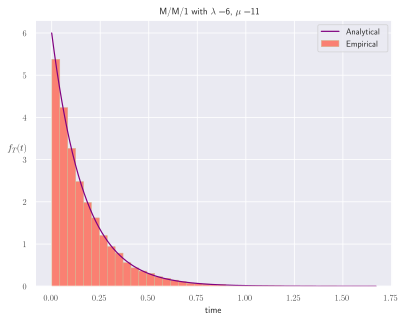

In [6]:
# Ideal PDF of Inter-arrival times :
t = np.linspace(0, np.max(arr_Times), 1000)
analytical_dist = arrival_rate * np.exp(-arrival_rate * t)

fig, axes = plt.subplots()
# Plot the ideal line
axes.plot(t, analytical_dist, color='purple', label='Analytical')
# Plot the empirical line
axes.hist(arr_Times, bins=41, density=True, linewidth=0.5, edgecolor='tan', color='salmon', label='Empirical')
axes.set_xlabel(f'time')
axes.set_ylabel(f'$f_T(t)$', rotation=0)
axes.set_title(f'M/M/1 with $\lambda =${arrival_rate}, $\mu = ${departure_rate}')
axes.legend()
fig.savefig(f'simulation_results/mm1_interArrivalTime_{arrival_rate}_{departure_rate}.pdf')
fig.savefig(f'simulation_results/mm1_interArrivalTime_{arrival_rate}_{departure_rate}.svg', transparent=True)

Observations:
1. The analytical distribution matches the empirically plotted density histogram.
2. The distribution of interarrival times is exponential with rate $\lambda$.

- State Probabilities

Analytical State Probabilities  in equilibrium i.e., when ($\lambda < \mu$),
\begin{align}
p_n &= \mathbb{P}(\text{Queue is in state }n) \\
    &= (1 - \rho) \rho^n\ \quad\ \ldots\ 0 \leq n.
\end{align}

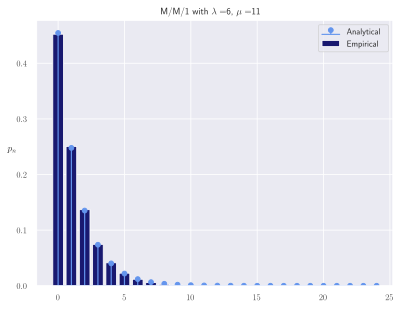

In [7]:
rho = arrival_rate / departure_rate
analytical_dist = []
for i in range(25):
    p_i = (rho ** i) * (1 - rho)
    analytical_dist.append(p_i)

# First, we will extract the unique states and their respective frequencies:
unique_elements, counts = np.unique(queue_history, return_counts=True)

total_count = np.sum(counts)

fig, axes = plt.subplots()
axes.stem(analytical_dist, linefmt='cornflowerblue', basefmt='cornflowerblue', label='Analytical')
axes.bar(unique_elements, counts / total_count, color='midnightblue', label='Empirical')
axes.set_ylabel(f'$p_n$', rotation=0)
axes.set_title(f'M/M/1 with $\lambda =${arrival_rate}, $\mu = ${departure_rate}')
axes.legend()
fig.savefig(f'simulation_results/mm1_stateProbs_{arrival_rate}_{departure_rate}.pdf')
fig.savefig(f'simulation_results/mm1_stateProbs_{arrival_rate}_{departure_rate}.svg', transparent=True)

Observations:
1. For the most part, the fit of the PMF found analytically and that found bar plotting the empirical results match up.
2. The mismatch in some states is due to the stochastic (random) variability of the experiment.

- Average number of customers and Variance of number of customers

Analytical Expressions (in equilibrium):
\begin{align}
\text{Mean number of customers} &:       \bar{N} = \frac{\rho}{1 - \rho} \\
\text{Variance of Number of customers} &: \text{var}(N) = \frac{\rho}{(1 - \rho)^2}
\end{align}

In [8]:
mean_empirical = np.mean(queue_history)
mean_analytical = rho / (1 - rho)

print(f'Expected mean value : {mean_analytical}\n -> Observed mean value : {mean_empirical}')

var_empirical = np.var(queue_history)
var_analytical = rho / ((1 - rho) ** 2)
print(f'Expected variance : {var_analytical}\n -> Observed variance : {var_empirical}')

Expected mean value : 1.1999999999999997
 -> Observed mean value : 1.1759086666666667
Expected variance : 2.6399999999999992
 -> Observed variance : 2.36634547432489


- Little's Law:
    - The average number of customers in a queue is equal to the product of the arrival rate times the average time spent in the queue.
    - $\bar{N} = \lambda \bar{\tau}$

In [9]:
print(f'Average number of customers in the queue = {mean_empirical}')
print(f'lambda * T_avg = {arrival_rate * np.mean(ind_Times)}')

Average number of customers in the queue = 1.1759086666666667
lambda * T_avg = 1.1743428761651138


Response time distribution

$\text{reponse time} (T) = \text{waiting time} + \text{service time}$

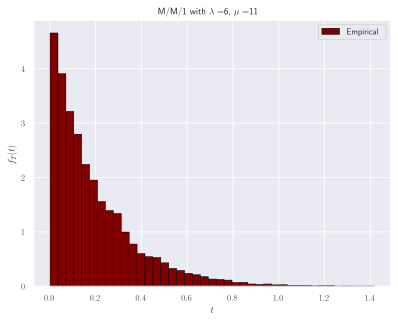

In [10]:
fig, axes = plt.subplots()
axes.hist(ind_Times, bins=41, edgecolor='black', linewidth=0.5, color='maroon', density=True, label='Empirical')
axes.set_xlabel(f'$t$')
axes.set_ylabel(f'$f_T(t)$')
axes.legend()
axes.set_title(f'M/M/1 with $\lambda = ${arrival_rate}, $\mu = ${departure_rate}')
fig.savefig(f'simulation_results/mm1_response_time_{arrival_rate}_{departure_rate}.pdf')
fig.savefig(f'simulation_results/mm1_response_time_{arrival_rate}_{departure_rate}.svg', transparent=True)

Observations:
1. Plotted the histogram of this quantity just out of interest and in search of new insights.

#### M/M/1/N - _Finite buffer case_ 

In [11]:
buffer_size = 10                            # Buffer size of the queue
queue_history, arr_Times, dep_Times, ind_Times = qm.m_m_1_N_q(total_simul_time, del_t, arrival_rate, departure_rate, buffer_size)

In [12]:
np.max(queue_history)                       # Maximum size of the queue at any point in time is atmost buffer_size

10

- Evolution of the state of the system

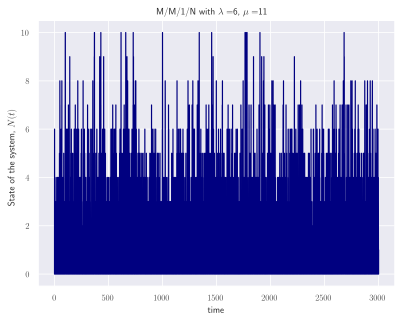

In [13]:
fig, axes = plt.subplots()
axes.plot(del_t * np.arange(int(total_simul_time / del_t)), queue_history, color='navy')
axes.set_xlabel(f'time')
axes.set_ylabel(f'State of the system, $N(t)$')
axes.set_title(f'M/M/1/N with $\lambda = ${arrival_rate}, $\mu = ${departure_rate}')
fig.savefig(f'simulation_results/mm1N_state_history_{arrival_rate}_{departure_rate}.pdf')
fig.savefig(f'simulation_results/mm1N_state_history_{arrival_rate}_{departure_rate}.svg', transparent=True)

- Distribution of Inter-Arrival times

Analytical Distribution :
    Inter-arrival times $\overset{i.i.d}{\sim} \text{Exponential}(\lambda)$

Empirical (effective) arrival rate at the queue = 5.985037739006483
Set arrival rate = 6


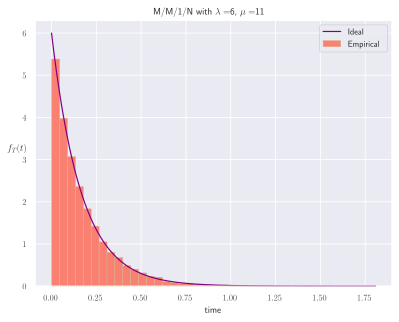

In [14]:
# Ideal PDF of Inter-arrival times :
t = np.linspace(0, max(arr_Times), 1000)
analytical_dist = arrival_rate * np.exp(-arrival_rate * t)

fig, axes = plt.subplots()
# Plot the analytical line
axes.plot(t, analytical_dist, color='purple', label='Ideal')
# Plot the empirical line
axes.hist(arr_Times, bins=41, density=True, linewidth=0.5, edgecolor='tan', color='salmon', label='Empirical')
axes.set_xlabel(f'time')
axes.set_ylabel(f'$f_T(t)$', rotation=0)
axes.set_title(f'M/M/1/N with $\lambda = ${arrival_rate}, $\mu = ${departure_rate}')
axes.legend()
fig.savefig(f'simulation_results/mm1N_interArrivalTime_{arrival_rate}_{departure_rate}.pdf')
fig.savefig(f'simulation_results/mm1N_interArrivalTime_{arrival_rate}_{departure_rate}.svg', transparent=True)

print(f'Empirical (effective) arrival rate at the queue = {1 / np.mean(arr_Times)}')
print(f'Set arrival rate = {arrival_rate}')

Discussion:
1. Here, we can see that the mean rate observed differs from the one that was set at the start of the experiment. This is due to the fact that the queue is of finite capacity. Some of the arrivals are turned away or dropped with some finite probability. The effective arrival rate which is captured in the empirical inter-arrival times is of only those that are accepted to the queue. Hence, this effective rate of arrival at the queue is less than what is expected.

2. Due to this very reason, the utilization of the system is lesser than the ratio $\frac{\lambda}{\mu}$. 

- State Probabilities

Analytical distribution under equilibrium $\lambda < \mu$ :

\begin{align}
    p_n &= \mathbb{P}(\text{system is in state n})\\
        &=  \frac{(1 - \rho) \rho ^ n}{1 - \rho ^{N + 1}}\ &&\quad\ \ldots\ 0 \leq n \leq N, \rho \neq 1\\
        &=  \frac{1}{N + 1}\ &&\quad\ \ldots\ 0 \leq n \leq N, \rho = 1\\
\end{align}

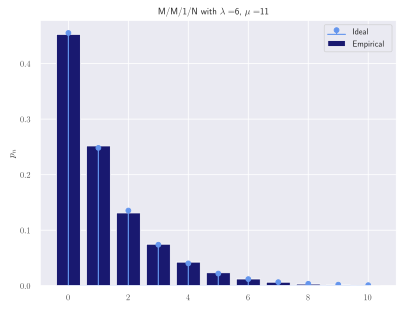

In [15]:
rho = arrival_rate / departure_rate
analytical_dist = []
for i in range(buffer_size+1):
    if rho == 1:
        analytical_dist.append(1 / (buffer_size + 1))
    else:
        p_i = (1 - rho) * (rho ** i) / (1 - (rho ** (buffer_size+1)))
        analytical_dist.append(p_i)

# First, we will extract the unique states and their respective frequencies:
unique_elements, counts = np.unique(queue_history, return_counts=True)

total_count = sum(counts)

fig, axes = plt.subplots()
axes.stem(analytical_dist, linefmt='cornflowerblue', basefmt='cornflowerblue', label='Ideal')
axes.bar(unique_elements, counts / total_count, color='midnightblue', label='Empirical')
axes.set_ylabel(f'$p_n$')
axes.set_title(f'M/M/1/N with $\lambda = ${arrival_rate}, $\mu = ${departure_rate}')
axes.legend()
fig.savefig(f'simulation_results/mm1N_stateProbs_{arrival_rate}_{departure_rate}.pdf')
fig.savefig(f'simulation_results/mm1N_stateProbs_{arrival_rate}_{departure_rate}.svg', transparent=True)

#### M/M/$\infty$ - Infinite server system

In [16]:
queue_history, arr_Times, dep_Times, ind_Times = qm.m_m_infinite_q(total_simul_time, del_t, arrival_rate, departure_rate)

- Evolution of the state of the system

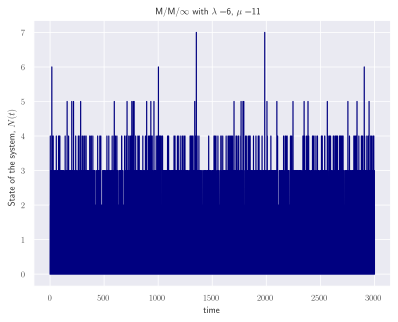

In [17]:
fig, axes = plt.subplots()
axes.plot(del_t * np.arange(int(total_simul_time / del_t)), queue_history, color='navy')
axes.set_xlabel(f'time')
axes.set_ylabel(f'State of the system, $N(t)$')
axes.set_title(f'M/M/$\infty$ with $\lambda = ${arrival_rate}, $\mu = ${departure_rate}')
fig.savefig(f'simulation_results/mmInf_state_history_{arrival_rate}_{departure_rate}.pdf')
fig.savefig(f'simulation_results/mmInf_state_history_{arrival_rate}_{departure_rate}.svg', transparent=True)

- Distribution of Inter-Arrival times

Analytical distribution : Inter-arrival times $\overset{i.i.d}{\sim} \text{Exponential}(\lambda)$

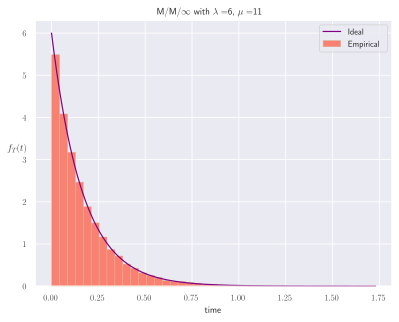

In [18]:
# Ideal PDF of Inter-arrival times :
t = np.linspace(0, np.max(arr_Times), 1000)
analytical_dist = arrival_rate * np.exp(-arrival_rate * t)

fig, axes = plt.subplots()
# Plot the ideal line
axes.plot(t, analytical_dist, color='purple', label='Ideal')
# Plot the empirical line
axes.hist(arr_Times, bins=41, density=True, linewidth=0.5, edgecolor='tan', color='salmon', label='Empirical')
axes.set_xlabel(f'time')
axes.set_ylabel(f'$f_T(t)$', rotation=0)
axes.set_title(f'M/M/$\infty$ with $\lambda = ${arrival_rate}, $\mu = ${departure_rate}')
axes.legend()
fig.savefig(f'simulation_results/mmInf_interArrivalTime_{arrival_rate}_{departure_rate}.pdf')
fig.savefig(f'simulation_results/mmInf_interArrivalTime_{arrival_rate}_{departure_rate}.svg', transparent=True)

- State Probabilities

Analytical state probabilities at equilibrium ($\lambda < \mu$).
\begin{align}
 p_n &= \mathbb{P}(\text{system is in state }n) \\
 &= \frac{\rho^n}{n!} e^{-\rho}\ &&\quad\ \ldots\ n \geq 0.\\
 \text{where, } \rho &= \frac{\lambda}{\mu} 
\end{align}


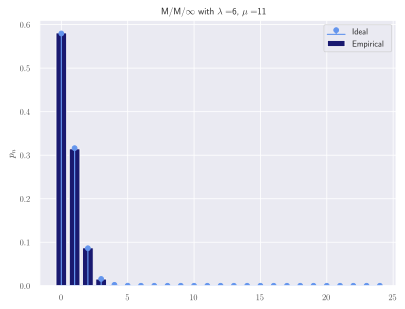

In [19]:
rho = arrival_rate / departure_rate
analytical_dist = []
for i in range(25):
    p_i = (rho ** i) * np.exp(-rho) / factorial(i)
    analytical_dist.append(p_i)

# First, we will extract the unique states and their respective frequencies:
unique_elements, counts = np.unique(queue_history, return_counts=True)

total_count = sum(counts)

fig, axes = plt.subplots()
axes.stem(analytical_dist, linefmt='cornflowerblue', basefmt='cornflowerblue', label='Ideal')
axes.bar(unique_elements, counts / total_count, color='midnightblue', label='Empirical')
axes.set_ylabel(f'$p_n$')
axes.set_title(f'M/M/$\infty$ with $\lambda = ${arrival_rate}, $\mu = ${departure_rate}')
axes.legend()
fig.savefig(f'simulation_results/mmInf_stateProbs_{arrival_rate}_{departure_rate}.pdf')
fig.savefig(f'simulation_results/mmInf_stateProbs_{arrival_rate}_{departure_rate}.svg', transparent=True)

- Average number of customers and Variance of number of customers

In [20]:
mean_empirical = np.mean(queue_history)
mean_analytical = rho 

print(f'Expected mean value : {mean_analytical}\n -> Observed mean value : {mean_empirical}')

var_empirical = np.var(queue_history)
var_analytical = rho 

print(f'Expected variance : {var_analytical}\n -> Observed variance : {var_empirical}')

Expected mean value : 0.5454545454545454
 -> Observed mean value : 0.5445306666666667
Expected variance : 0.5454545454545454
 -> Observed variance : 0.5462483530595551


- Departure time (per user) distribution:

In this case, since a customer need not wait in a queue and directly goes into service, it is expected that the time spent in the `queueing facility` is distributed as $\text{Exponential}(\mu)$.

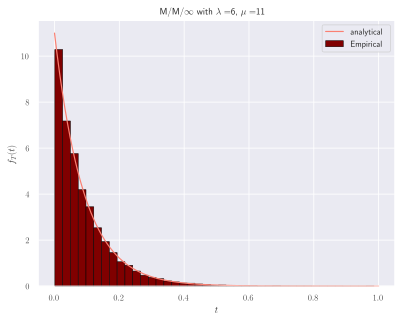

In [21]:
# Analytical Distribution:
x = np.linspace(0, 1, 1000)      
y = departure_rate * np.exp(-departure_rate * x)

fig, axes = plt.subplots()
axes.plot(x, y, color='salmon', label='analytical')
axes.hist(ind_Times, bins=41, edgecolor='black', linewidth=0.5, color='maroon', density=True, label='Empirical')
axes.set_xlabel(f'$t$')
axes.set_ylabel(f'$f_T(t)$')
axes.legend()
axes.set_title(f'M/M/$\infty$ with $\lambda = ${arrival_rate}, $\mu = ${departure_rate}')
fig.savefig(f'simulation_results/mm1_response_time_{arrival_rate}_{departure_rate}.pdf')
fig.savefig(f'simulation_results/mm1_response_time_{arrival_rate}_{departure_rate}.svg', transparent=True)

#### M/M/m - Multiple but Finite Servers

In [22]:
num_servers = 10 
queue_history, arr_Times, dep_Times, ind_Times = qm.m_m_m_q(total_simul_time, del_t, arrival_rate, departure_rate, num_servers)

- Evolution of the state of the system

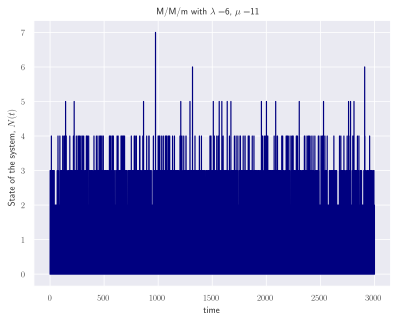

In [23]:
fig, axes = plt.subplots()
axes.plot(del_t * np.arange(int(total_simul_time / del_t)), queue_history, color='navy')
axes.set_xlabel(f'time')
axes.set_ylabel(f'State of the system, $N(t)$')
axes.set_title(f'M/M/m with $\lambda = ${arrival_rate}, $\mu = ${departure_rate}')
fig.savefig(f'simulation_results/mmInf_state_history_{arrival_rate}_{departure_rate}.pdf')
fig.savefig(f'simulation_results/mmInf_state_history_{arrival_rate}_{departure_rate}.svg', transparent=True)

- Distribution of Inter-Arrival times

Analytical Distribution : Inter-Arrival Times $\overset{i.i.d}{\sim} \text{Exponential}(\lambda)$  

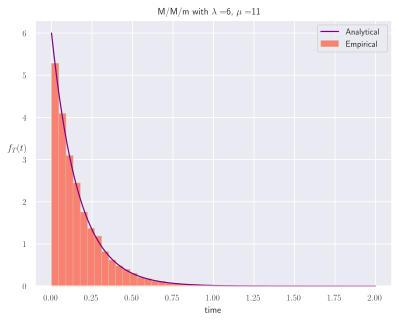

In [24]:
# Analytical PDF of Inter-arrival times :
t = np.linspace(0, 2, 1000)
analytical_dist = arrival_rate * np.exp(-arrival_rate * t)

fig, axes = plt.subplots()
# Plot the analytical PDF
axes.plot(t, analytical_dist, color='purple', label='Analytical')
# Plot the empirical line
axes.hist(arr_Times, bins=41, density=True, linewidth=0.5, edgecolor='tan', color='salmon', label='Empirical')
axes.set_xlabel(f'time')
axes.set_ylabel(f'$f_T(t)$', rotation=0)
axes.set_title(f'M/M/m with $\lambda = ${arrival_rate}, $\mu = ${departure_rate}')
axes.legend()
fig.savefig(f'simulation_results/mmm_interArrivalTime_{arrival_rate}_{departure_rate}.pdf')
fig.savefig(f'simulation_results/mmm_interArrivalTime_{arrival_rate}_{departure_rate}.svg', transparent=True)

- State Probabilities (in equilibrium)

\begin{align} 
            p_0 &= \left[ 1 + \sum_{n=1}^{m-1} \frac{1}{n!} \left( \frac{\lambda}{\mu} \right)^n + \sum_{n=m}^{\infty} \frac{1}{m^{n-m}} \frac{1}{m!} \left( \frac{\lambda}{\mu} \right)^n \right]^{-1}\\
            p_n &= \frac{\lambda^n}{n! \mu^n} p_0 \quad \text{if} \ 1 \leq n < m\\
            p_n &= \frac{\lambda^n}{m^{n-m} m! \mu^n} p_0 \quad \text{if} \ n \geq m.
\end{align}

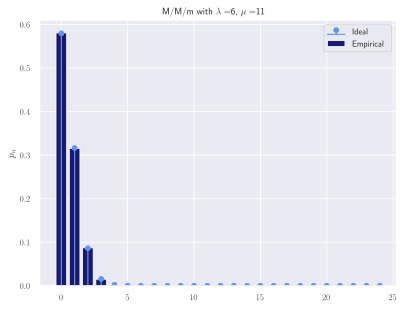

In [25]:
rho = arrival_rate / departure_rate
rho_prime = arrival_rate / (num_servers * departure_rate)
analytical_dist = []
p_0_inv = 1
for n in range(1, num_servers):
    p_0_inv += (1 / factorial(n)) * (rho ** n)
for n in range(num_servers, 2 ** 10):
    # Hopefully the sum will converge 
    p_0_inv += (1 / (num_servers ** (n - num_servers))) * (1 / factorial(num_servers)) * (rho ** n)

p_0 = 1 / p_0_inv

for n in range(num_servers):
    p_i = (1 / factorial(n)) * (rho ** n) * p_0
    analytical_dist.append(p_i)
for n in range(num_servers, 25):
    p_i = (1 / (num_servers ** (n - num_servers))) * (1 / factorial(num_servers)) * (rho ** n) * p_0
    analytical_dist.append(p_i)

# First, we will extract the unique states and their respective frequencies:
unique_elements, counts = np.unique(queue_history, return_counts=True)

total_count = sum(counts)

fig, axes = plt.subplots()
axes.stem(analytical_dist, linefmt='cornflowerblue', basefmt='cornflowerblue', label='Ideal')
axes.bar(unique_elements, counts / total_count, color='midnightblue', label='Empirical')
axes.set_ylabel(f'$p_n$')
axes.set_title(f'M/M/m with $\lambda = ${arrival_rate}, $\mu = ${departure_rate}')
axes.legend()
fig.savefig(f'simulation_results/mmm_stateProbs_{arrival_rate}_{departure_rate}.pdf')
fig.savefig(f'simulation_results/mmm_stateProbs_{arrival_rate}_{departure_rate}.svg', transparent=True)